In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 2024
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

discount_factor = 0.99
num_episodes = 1000
learning_rate = 0.001
hidden_size = 16

In [2]:
class policy_network(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [3]:
def preprocess_state(state):
    normalized_state = torch.as_tensor(state, dtype=torch.float32, device=device)

    return normalized_state

In [4]:
def compute_returns(rewards):

    t_steps = np.arange(len(rewards))
    r = rewards * discount_factor ** t_steps # Compute discounted rewards for each time step

    # Compute the discounted cumulative sum in reverse order and then reverse it again to restore the original order.
    r = np.cumsum(r[::-1])[::-1] / discount_factor ** t_steps

    return r

In [5]:
def compute_loss(log_probs, returns):

    loss = []
    for log_prob, returns in zip(log_probs, returns):
        loss.append(log_prob * returns)

    return -torch.stack(loss).sum()

In [6]:
def plot_training_results(rewards, losses):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(rewards)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Episode Reward')
    ax1.set_title('Training Rewards')
    ax1.grid(True)

    ax2.plot(losses)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Loss per time step')
    ax2.set_title('Training Losses')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


def test_and_create_gif(policy, gif_filename='cartpole_test.gif'):
    test_env = gym.make("CartPole-v1", max_episode_steps=500, render_mode="rgb_array")
    test_env = gym.wrappers.NormalizeObservation(test_env)

    frames = []
    total_reward = 0

    state, _ = test_env.reset(seed=seed)
    done = False
    truncation = False

    print("Testing trained policy and creating GIF...")

    while not done and not truncation:
        frame = test_env.render()
        frames.append(Image.fromarray(frame))

        state_tensor = preprocess_state(state)
        action_probs = policy(state_tensor)
        action = torch.argmax(action_probs, dim=0).item()

        state, reward, done, truncation, _ = test_env.step(action)
        total_reward += reward

    test_env.close()

    if frames:
        frames[0].save(
            gif_filename,
            save_all=True,
            append_images=frames[1:],
            duration=50,  # 50ms per frame
            loop=0
        )
        print(f"GIF saved as '{gif_filename}' with {len(frames)} frames")
        print(f"Test episode reward: {total_reward}")
    else:
        print("No frames captured for GIF")

In [7]:
def train(env):
    # Define the policy network and its optimizer
    policy = policy_network(input_size=4, output_size=2).to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=learning_rate)

    # Lists to store episode rewards and losses for plotting
    episode_rewards = []
    episode_losses = []

    # Main training loop that loops over each episode
    for episode in range(1, num_episodes + 1):
        state, _ = env.reset(seed=seed) # Reset the environment and get the initial state

        # Initialize empty lists to store log probabilities and rewards for the episode
        log_probs = []
        episode_reward = []

        # Loop until the episode is done
        while True:
            state = preprocess_state(state) # Preprocesses the state to convert it to tensor
            action_probs = policy(state) # Get action probabilities from the policy network

            # Sample an action from the action probabilities
            dist = torch.distributions.Categorical(action_probs)  # Create a categorical distribution for the action probabilities
            action = dist.sample()

            # Compute the log probability of the sampled action
            log_prob = dist.log_prob(action)
            log_probs.append(log_prob)

            # Take a step in the environment
            next_state, reward, done, truncation, _ = env.step(action.item())
            episode_reward.append(reward)

            state = next_state # Update the current state

            if done or truncation: # if the episode is done or truncated
                returns = compute_returns(episode_reward) # Compute the returns (discounted sum of rewards) for the episode
                loss = compute_loss(log_probs, returns)  # Compute the loss for the episode using the log probabilities and returns

                optimizer.zero_grad() # Zero the gradients of the optimizer
                loss.backward() # Backpropagate the loss
                optimizer.step() # Update the parameters of the policy network

                total_reward = sum(episode_reward) # Compute the total reward for the episode
                episode_rewards.append(total_reward)
                episode_losses.append(loss.item())

                if episode % 50 == 0:
                    print(f"Episode {episode}, Reward: {total_reward:.2f}, Loss: {loss.item():.4f}")


                break # Exit the episode loop

    # Plot training results
    plot_training_results(episode_rewards, episode_losses)

    return policy

In [8]:
# make function to compute action distribution
def get_policy(obs, logits_net):
    logits = logits_net(obs)
    return torch.distributions.Categorical(logits=logits)

# make action selection function (outputs int actions, sampled from policy)
def get_action(obs, logits_net):
    return get_policy(obs, logits_net).sample().item()

def train(env, batch_size=500, epochs=1000):

    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.n

    # make core of policy network
    logits_net = policy_network(input_size=obs_dim, hidden_size=hidden_size, output_size=n_acts).to(device)

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(obs, act, weights):
        weights_norm = (weights - weights.mean()) / (weights.std() + 1e-8)  # Normalize weights
        logp = get_policy(obs, logits_net).log_prob(act)
        return -(logp * weights_norm).mean()

    # make optimizer
    optimizer = torch.optim.Adam(logits_net.parameters(), lr=learning_rate)

    # collect data for plot_training_results
    rewards = []
    losses = []

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode  _ = env.step(act)returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs, _ = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False

        # collect experience by acting in the environment with current policy
        while True:
            # save obs
            batch_obs.append(obs.copy())

            # act in the environment
            obs = np.asarray(obs, dtype=np.float32)  # Ensure obs is a numpy array
            act = get_action(torch.as_tensor(obs, dtype=torch.float32).to(device), logits_net)
            obs, rew, done, truncation, _ = env.step(act)

            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)

            if done or truncation:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                # the weight for each logprob(a|s) is R(tau)
                batch_weights += [ep_ret] * ep_len

                # reset episode-specific variables
                obs, _ = env.reset()
                done, ep_rews = False, []

                # won't render again this epoch
                finished_rendering_this_epoch = True

                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

        # take a single policy gradient update step
        optimizer.zero_grad()
        batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32).to(device),
                                  act=torch.as_tensor(batch_acts, dtype=torch.int32).to(device),
                                  weights=torch.as_tensor(batch_weights, dtype=torch.float32).to(device)
                                  )
        batch_loss.backward()
        optimizer.step()
        return batch_loss, batch_rets, batch_lens

    # training loop _ = env.step(act)
    for i in tqdm(range(epochs)):
        batch_loss, batch_rets, batch_lens = train_one_epoch()
        rewards += batch_rets
        losses += [batch_loss.item()] * len(batch_rets)

    return rewards, losses, logits_net

In [9]:
# Create environment for training (no rendering)
env = gym.make("CartPole-v1", max_episode_steps=500)
env = gym.wrappers.NormalizeObservation(env)
env.action_space.seed(seed)

print("Starting REINFORCE training...")
rewards, losses, logits_net = train(env)


Starting REINFORCE training...


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/h6/l21knyzn0j1919wpph_4f6qr0000gn/T/ipykernel_449/3491903526.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1750198230540/work/torch/csrc/utils/tensor_new.cpp:257.)
  batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32).to(device),
  3%|▎         | 26/1000 [00:02<01:26, 11.27it/s]


KeyboardInterrupt: 

In [ ]:
env.close()

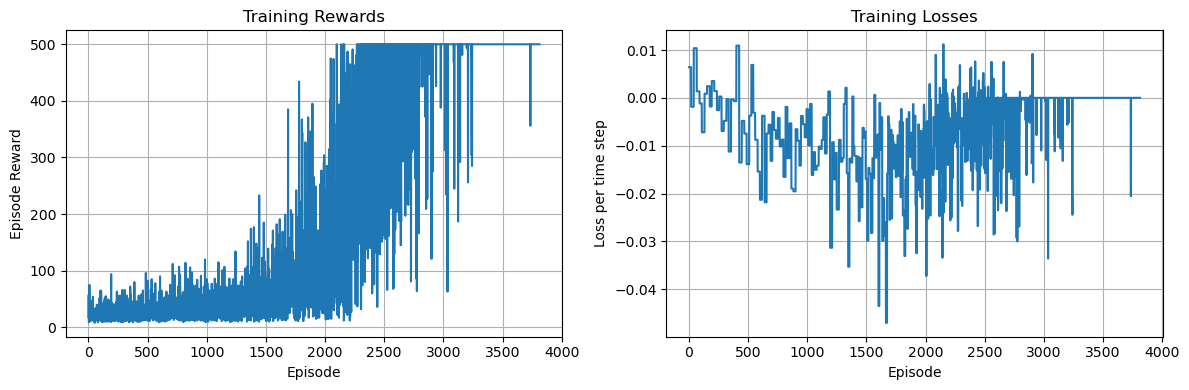

In [ ]:
plot_training_results(rewards, losses)

In [ ]:
def test(logits_net, num_episodes):
    for i in range(num_episodes):
        obs, _ = env.reset()
        done = False
        truncation = False
        total_reward = 0
        while not done and not truncation:
            action = get_action(torch.as_tensor(obs, dtype=torch.float32).to(device), logits_net)
            obs, reward, done, truncation, _ = env.step(action)
            total_reward += reward
        print(f"Episode {i+1}: Total Reward: {total_reward}")

In [ ]:
test(logits_net, 5)

Episode 1: Total Reward: 500.0
Episode 2: Total Reward: 500.0
Episode 3: Total Reward: 500.0
Episode 4: Total Reward: 500.0
Episode 5: Total Reward: 500.0
